### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [5]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


 # Loading Datasets

In [6]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ERA5_16zones_avg_std_10D.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [7]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/tc_act_sind.csv')

In [8]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [9]:
df_target = df_target.rename(columns={'Unnamed: 0': 'DATE'})
df_target = df_target.set_index('DATE')
df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['Label']

df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 15310, dtype: int64

# Build the dataset to train XGBoost

In [10]:
# Consider both the values of variables today and the compressed version of timeseries
merged_df = pd.merge(df_mjo_enso, df_era5_scaled, left_index=True, right_index=True)

# Consider only the compressed version of the timeseries for the era5 and mjo-nino datasets
merged_df

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [11]:
from datetime import datetime

def day_of_year(date_string):
    date_object = datetime.strptime(date_string, '%Y-%m-%d')
    return date_object.timetuple().tm_yday

# Convert to list of day numbers
day_numbers = [day_of_year(date_str) for date_str in merged_df.index]
merged_df['yday'] = day_numbers

merged_df

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10,yday
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453,32
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,33
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,34
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,35
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929,361
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,362
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,363


## Split in train test sets

In [12]:
# Split train-test with dates
X_train = merged_df[merged_df.index < '2012'].values
X_test = merged_df[merged_df.index > '2012'].values

y_train = df_target[df_target.index < '2012'].values
y_test  = df_target[df_target.index > '2012'].values

In [13]:
print('TRAIN SET:        ', X_train.shape, y_train.shape)
print('\nTEST SET :        ', X_test.shape , y_test.shape)

neg_N = y_train.shape[0] - np.count_nonzero(y_train)
pos_N = np.count_nonzero(y_train)

print('POSITIVE SAMPLES: ', pos_N)
print('NEGATIVE SAMPLES: ', neg_N)

neg_pos_ratio = round(neg_N/pos_N, 2)
print('NEG-POS RATIO:    ', neg_pos_ratio)

TRAIN SET:         (11657, 6959) (11657,)

TEST SET :         (3653, 6959) (3653,)
POSITIVE SAMPLES:  1669
NEGATIVE SAMPLES:  9988
NEG-POS RATIO:     5.98


## Build dataset to predict at d+1, d+2, ..., d+5


In [14]:
max_lead_time = 10
X_train_future = []
y_train_future = []
X_test_future = []
y_test_future = []

for i in range(max_lead_time):
  X_train_future.append(X_train[:len(X_train)-i])
  y_train_future.append(y_train[i:])
  X_test_future.append(X_test[:len(X_test)-i])
  y_test_future.append(y_test[:len(y_test)-i])
  print('X_train at t+{}:'.format(i+1), X_train_future[i].shape, y_train_future[i].shape)
  print('X_test at t+{} :'.format(i+1), X_test_future[i].shape , y_test_future[i].shape)
  print(X_train_future[i].shape[0] + X_test_future[i].shape[0])
  print('------------------------------------------------')

X_train at t+1: (11657, 6959) (11657,)
X_test at t+1 : (3653, 6959) (3653,)
15310
------------------------------------------------
X_train at t+2: (11656, 6959) (11656,)
X_test at t+2 : (3652, 6959) (3652,)
15308
------------------------------------------------
X_train at t+3: (11655, 6959) (11655,)
X_test at t+3 : (3651, 6959) (3651,)
15306
------------------------------------------------
X_train at t+4: (11654, 6959) (11654,)
X_test at t+4 : (3650, 6959) (3650,)
15304
------------------------------------------------
X_train at t+5: (11653, 6959) (11653,)
X_test at t+5 : (3649, 6959) (3649,)
15302
------------------------------------------------
X_train at t+6: (11652, 6959) (11652,)
X_test at t+6 : (3648, 6959) (3648,)
15300
------------------------------------------------
X_train at t+7: (11651, 6959) (11651,)
X_test at t+7 : (3647, 6959) (3647,)
15298
------------------------------------------------
X_train at t+8: (11650, 6959) (11650,)
X_test at t+8 : (3646, 6959) (3646,)
15296
-

# Evalute models

In [18]:
models = []
for i in range(max_lead_time):
  models.append(pickle.load(open('./10_Black_Boxes/models/XGBoost/XGBoost_t+{}.dat'.format(i+1), "rb")))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:25:20] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:25:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:25:21] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:25:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:25:22] WARNING: /workspace/src/gbm/gbtree.cc:3

In [19]:
from metrics import TCStats

res_train   = []
res_test    = []
predictions = []

for i in range(max_lead_time):
  prediction_train = models[i].predict(X_train_future[i]).transpose()
  d = TCStats(y_train_future[i], prediction_train, y_train_future[0], i+1)
  d = np.array(d)
  res_train.append(d)

  prediction_test = models[i].predict(X_test_future[i]).transpose()
  d = TCStats(y_test_future[i], prediction_test, y_test_future[0], i+1)
  d = np.array(d)
  res_test.append(d)

  predictions.append(prediction_test)

  accuracy = sklearn.metrics.accuracy_score(y_test_future[i], prediction_test)
  recall   = sklearn.metrics.recall_score(y_test_future[i], prediction_test)
  f1       = sklearn.metrics.f1_score(y_test_future[i], prediction_test)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

Evaluation at t+1
ACCURACY:  0.8894059676977827 RECALL:  0.7519685039370079 F1:  0.654109589041096
------------------------------------------------------
Evaluation at t+2
ACCURACY:  0.8737677984665937 RECALL:  0.6968503937007874 F1:  0.6056458511548332
------------------------------------------------------
Evaluation at t+3
ACCURACY:  0.8652423993426458 RECALL:  0.6850393700787402 F1:  0.5858585858585857
------------------------------------------------------
Evaluation at t+4
ACCURACY:  0.8512328767123287 RECALL:  0.6633858267716536 F1:  0.5538208709942481
------------------------------------------------------
Evaluation at t+5
ACCURACY:  0.8289942449986297 RECALL:  0.6220472440944882 F1:  0.5031847133757962
------------------------------------------------------
Evaluation at t+6
ACCURACY:  0.8146929824561403 RECALL:  0.5846456692913385 F1:  0.46771653543307085
------------------------------------------------------
Evaluation at t+7
ACCURACY:  0.8034000548395942 RECALL:  0.48818897637

In [20]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_train = pd.DataFrame(res_train, columns=headers_list)
df_metrics_train = df_metrics_train.set_index('Window Len')
df_metrics_train

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,1669,2109,0,0,463,1646,23,9525,21.95%,78.05%,99.76%,0.24%,0.9862,0.8714,0.2195,0.9862,0.9583
2,1668,2179,0,0,527,1652,16,9461,24.19%,75.81%,99.83%,0.17%,0.9904,0.8589,0.2419,0.9904,0.9534
3,1667,2314,0,0,655,1659,8,9333,28.31%,71.69%,99.91%,0.09%,0.9952,0.8335,0.2831,0.9952,0.9431
4,1666,2377,0,0,723,1654,12,9265,30.42%,69.58%,99.87%,0.13%,0.9928,0.8182,0.3042,0.9928,0.9369
5,1665,2504,0,0,852,1652,13,9136,34.03%,65.97%,99.86%,0.14%,0.9922,0.7925,0.3403,0.9922,0.9258
6,1664,2596,0,0,944,1652,12,9044,36.36%,63.64%,99.87%,0.13%,0.9928,0.7756,0.3636,0.9928,0.918
7,1663,2545,0,0,895,1650,13,9093,35.17%,64.83%,99.86%,0.14%,0.9922,0.7842,0.3517,0.9922,0.9221
8,1662,2531,0,0,884,1647,15,9104,34.93%,65.07%,99.84%,0.16%,0.991,0.7856,0.3493,0.991,0.9228
9,1662,2581,0,0,934,1647,15,9053,36.19%,63.81%,99.83%,0.17%,0.991,0.7763,0.3619,0.991,0.9185


In [21]:
headers_list = ["Window Len", "#Real anomalies", "#Predicted anomalies", "Mean Alert Distance", "Standard Deviation", " N False positive", " N True positive"," N False negative","N True Negative","False Positive Rate","True positive rate/Precision", "True Negative Rate", "False Negative Rate", "Recall","F1","False Alarm Ratio","POD","Accuracy"]

df_metrics_test = pd.DataFrame(res_test, columns=headers_list)
df_metrics_test = df_metrics_test.set_index('Window Len')
df_metrics_test

,#Real anomalies,#Predicted anomalies,Mean Alert Distance,Standard Deviation,N False positive,N True positive,N False negative,N True Negative,False Positive Rate,True positive rate/Precision,True Negative Rate,False Negative Rate,Recall,F1,False Alarm Ratio,POD,Accuracy
Window Len,,,,,,,,,,,,,,,,,
1,508,660,0,0,278,382,126,2867,42.12%,57.88%,95.79%,4.21%,0.752,0.6541,0.4212,0.752,0.8894
2,508,661,0,0,307,354,154,2837,46.44%,53.56%,94.85%,5.15%,0.6969,0.6056,0.4644,0.6969,0.8738
3,508,680,0,0,332,348,160,2811,48.82%,51.18%,94.61%,5.39%,0.685,0.5859,0.4882,0.685,0.8652
4,508,709,0,0,372,337,171,2770,52.47%,47.53%,94.19%,5.81%,0.6634,0.5538,0.5247,0.6634,0.8512
5,508,748,0,0,432,316,192,2709,57.75%,42.25%,93.38%,6.62%,0.622,0.5032,0.5775,0.622,0.829
6,508,762,0,0,465,297,211,2675,61.02%,38.98%,92.69%,7.31%,0.5846,0.4677,0.6102,0.5846,0.8147
7,508,705,0,0,457,248,260,2682,64.82%,35.18%,91.16%,8.84%,0.4882,0.4089,0.6482,0.4882,0.8034
8,508,606,0,0,408,198,310,2730,67.33%,32.67%,89.80%,10.20%,0.3898,0.3555,0.6733,0.3898,0.8031
9,508,594,0,0,392,202,306,2745,65.99%,34.01%,89.97%,10.03%,0.3976,0.3666,0.6599,0.3976,0.8085


In [22]:
def brier_skill_score(y_true, y_prob):
    """
    Calculate Brier Skill Score.

    Parameters:
    - y_true: numpy array or pandas Series, true binary labels (0 or 1).
    - y_prob: numpy array or pandas Series, predicted probabilities for the positive class.

    Returns:
    - Brier Skill Score
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Brier Score for the model (predicted probabilities)
    brier_model = np.mean((y_true - y_prob)**2)

    # Brier Score for the climatology (mean of true labels)
    brier_climatology = np.mean((y_true - np.mean(y_true))**2)

    # Brier Skill Score
    brier_skill_score = 1 - (brier_model / brier_climatology)

    return brier_skill_score


bss = []
for i in range(max_lead_time):
  bss.append(brier_skill_score(y_test_future[i], predictions[i]))
  print('BRIER SKILL SCORE AT t+{}: '.format(i+1), brier_skill_score(y_test_future[i], predictions[i]))

BRIER SKILL SCORE AT t+1:  0.07626653981447873
BRIER SKILL SCORE AT t+2:  -0.0541088136883654
BRIER SKILL SCORE AT t+3:  -0.12504227617427555
BRIER SKILL SCORE AT t+4:  -0.2417174977570835
BRIER SKILL SCORE AT t+5:  -0.42700930292022954
BRIER SKILL SCORE AT t+6:  -0.5459952856211445
BRIER SKILL SCORE AT t+7:  -0.6398340160490452
BRIER SKILL SCORE AT t+8:  -0.642193984834114
BRIER SKILL SCORE AT t+9:  -0.5965213266097555
BRIER SKILL SCORE AT t+10:  -0.6080291860838825


## Plot results

In [25]:
precision_arr = []
for i in range(10):
  precision_arr.append(sklearn.metrics.precision_score(y_test_future[i], predictions[i]))

precision_arr

[0.5787878787878787,
 0.5355521936459909,
 0.5117647058823529,
 0.47531734837799716,
 0.42245989304812837,
 0.38976377952755903,
 0.3517730496453901,
 0.32673267326732675,
 0.3400673400673401,
 0.3474178403755869]

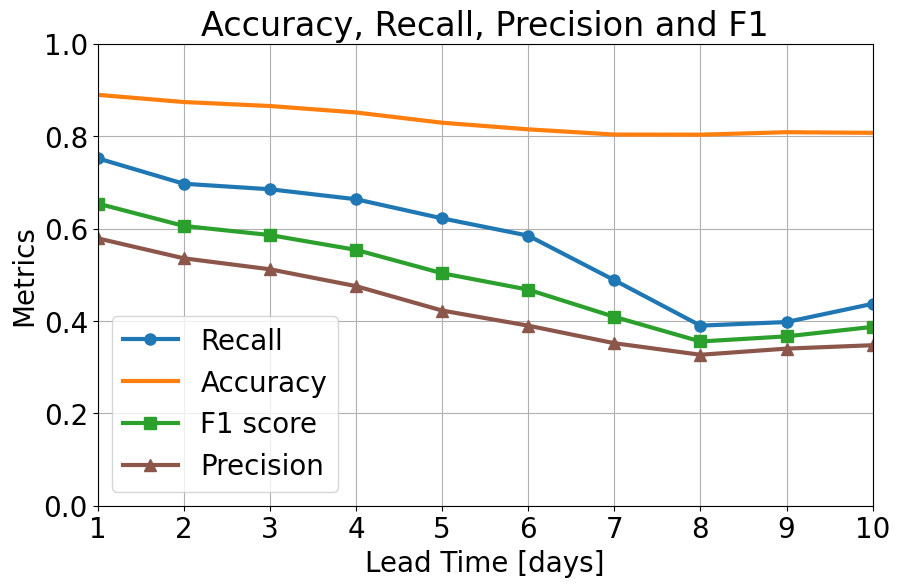

In [30]:
import matplotlib

test_pod = df_metrics_test['POD'].values.astype(float)
test_acc = df_metrics_test['Accuracy'].values.astype(float)
test_f1 = df_metrics_test['F1'].values.astype(float)
test_far = df_metrics_test['False Alarm Ratio'].values.astype(float)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, test_pod, label='Recall', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Accuracy
plt.plot(x, test_acc, label='Accuracy', color='C1', linewidth=3, markersize=8)
# Plotting F1
plt.plot(x, test_f1, label='F1 score', marker='s', color='C2', linewidth=3, markersize=8)
# Plotting FAR
plt.plot(x, precision_arr, label='Precision', marker='^', color='C5', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall, Precision and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

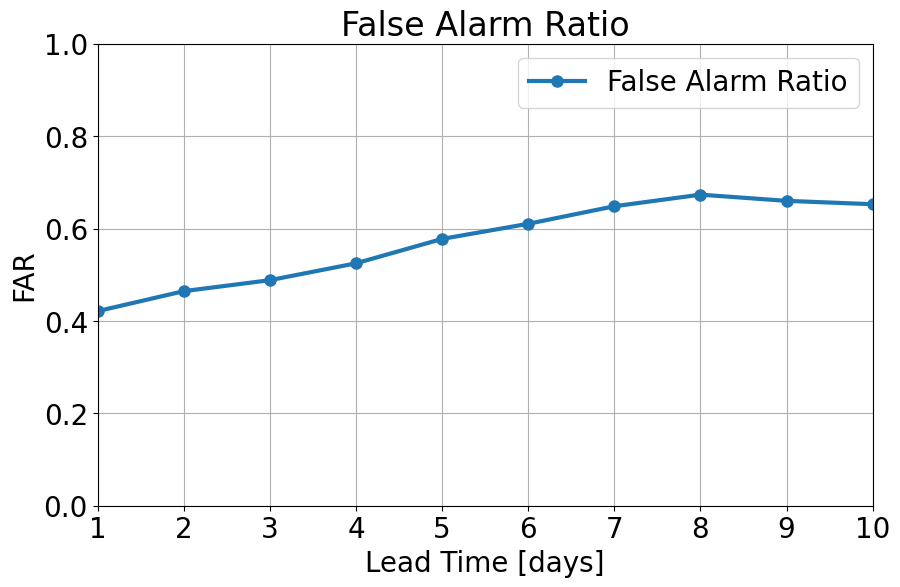

In [32]:
test_far = df_metrics_test['False Alarm Ratio'].values.astype(float)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting FAR
plt.plot(x, test_far, label='False Alarm Ratio', marker='o', color='C0', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('FAR')
plt.title('False Alarm Ratio')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
bss_perc = [elem*100 for elem in bss]

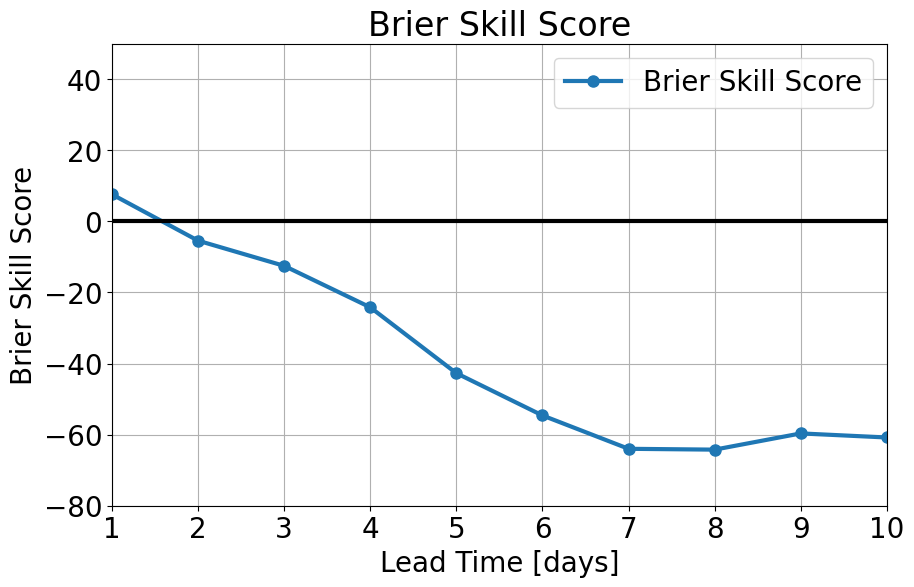

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Plotting BSS
plt.plot(x, bss_perc, label='Brier Skill Score', marker='o', color='C0', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(-80, 50)  # Adjust the range based on your data
plt.xticks(x)

plt.axhline(y=0, color='black', linewidth=3)
# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Score')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
models[0]

XGBRFClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bytree=0.6851582461711432,
                device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eta=0.1, eval_metric=None,
                feature_types=None, gamma=0.028685724425317586,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=41, max_leaves=102,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=223, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=42, ...)

In [ ]:
tp = df_metrics_test[' N True positive'].values
tn = df_metrics_test['N True Negative'].values
fp = df_metrics_test[' N False positive'].values
fn = df_metrics_test[' N False negative'].values

tp = [ int(x) for x in tp ]
tn = [ int(x) for x in tn ]
fp = [ int(x) for x in fp ]
fn = [ int(x) for x in fn ]

print(tp)
print(tn)
print(fp)
print(fn)



[382, 354, 348, 337, 316, 297, 248, 198, 202, 222]
[2867, 2837, 2811, 2770, 2709, 2675, 2682, 2730, 2745, 2719]
[278, 307, 332, 372, 432, 465, 457, 408, 392, 417]
[126, 154, 160, 171, 192, 211, 260, 310, 306, 286]


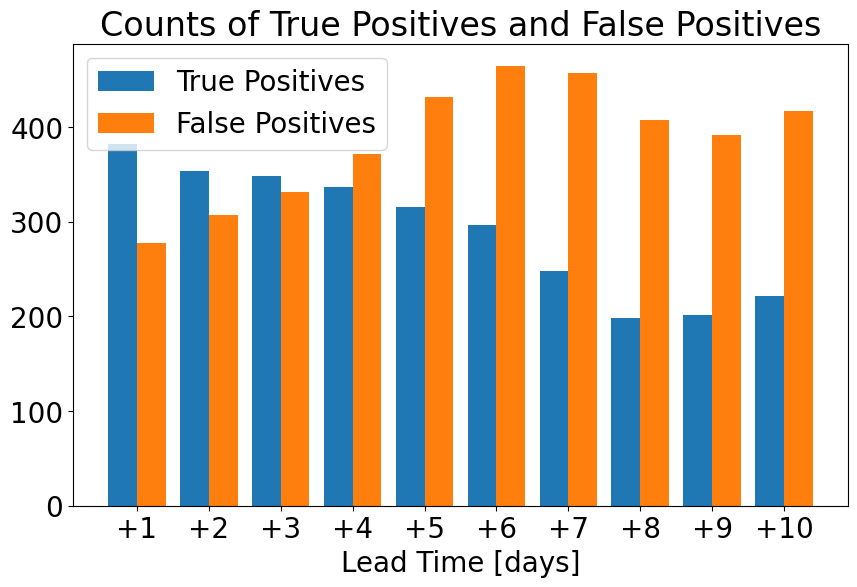

In [ ]:
# Data
days = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']

fig, ax = plt.subplots(figsize=(10,6))


# Bar width
bar_width = 0.4

# Positions for the bars
pos_tp = range(len(days))
pos_fp = [p + bar_width for p in pos_tp]

# Plot tp and tn
ax.bar(pos_tp, tp, width=bar_width, label='True Positives')
ax.bar(pos_fp, fp, width=bar_width, label='False Positives')

# Set x-axis ticks and labels
ax.set_xticks([p + bar_width / 2 for p in pos_tp])
ax.set_xticklabels(days)

# Add labels and legend
ax.set_xlabel('Lead Time [days]')
ax.set_ylabel('')
ax.set_title('Counts of True Positives and False Positives')
ax.legend()

plt.show()

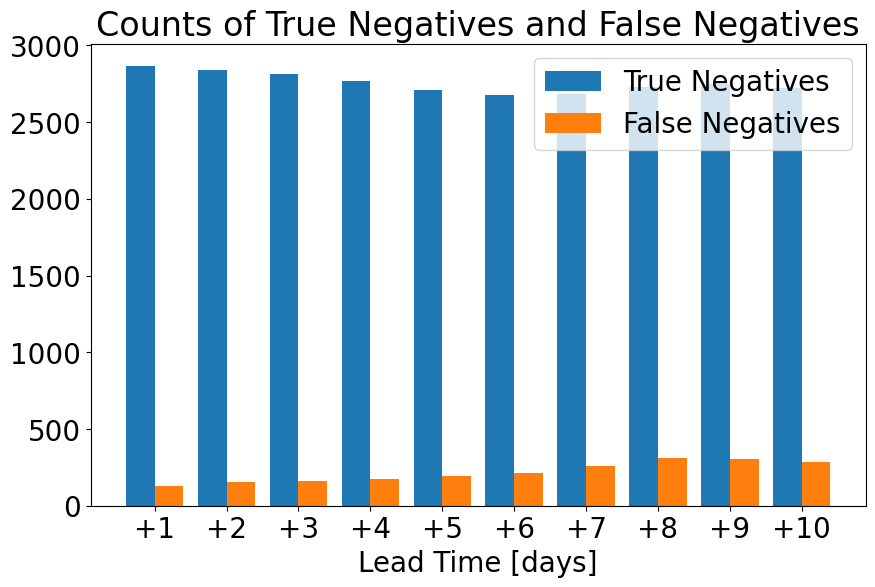

In [ ]:
# Data
days = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']

fig, ax = plt.subplots(figsize=(10,6))


# Bar width
bar_width = 0.4

# Positions for the bars
pos_tn = range(len(days))
pos_fn = [p + bar_width for p in pos_tn]

# Plot tp and tn
ax.bar(pos_tn, tn, width=bar_width, label='True Negatives')
ax.bar(pos_fn, fn, width=bar_width, label='False Negatives')

# Set x-axis ticks and labels
ax.set_xticks([p + bar_width / 2 for p in pos_tp])
ax.set_xticklabels(days)

# Add labels and legend
ax.set_xlabel('Lead Time [days]')
ax.set_ylabel('')
ax.set_title('Counts of True Negatives and False Negatives')
ax.legend()

plt.show()